# Analysis of random three-body problems generated by @ThreeBodyBot

This notebook generates a pretty suite of plots based on the animations posted to the Twitter account. Each time the script is run it tries to find a solution that lasts at least 15 years, with a maximum length of 60 years, with a maximum of 2000 iterations given to find a solution that satisfies that length criteria. If it can't find a solution (which is pretty rare) it makes it anyways, so extremely short animations (with length < 15 years) are the result of this rare condition. Right now I'm currently tracking the date the simulation was run, the simulation lengths, the masses, radii, how it ended (collision, ejection, timed out), which things collided (if there was a collision), the initial conditions, and the number of iterations it took to randomly arrive at that solution. This tracking started on 1/10/2021, but the notebook is only periodically updated with the latest results to Github. 

In [1]:
using DataFrames, Dates, Plots, Plots.Measures

In [2]:
function getDF(file = "3BodyStats.txt") #reads in data output by threeBodyProb.jl each night and puts into DF
    lines = readlines(file)
    Types = [Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64]
    names = [:Date,:Length,:m1,:m2,:m3,:r1,:r2,:r3,:collisionBool,:collision1,:collision2,:x1,:y1,:x2,:y2,:x3,:y3,:vx1,:vy1,:vx2,:vy2,:vx3,:vy3,:iter]
    df = DataFrame(Types,names,length(lines))
    for i = 1:length(lines)
        s = split(lines[i],",")
        df.Date[i] = parse(Date,s[1])
        df.Length[i] = parse(Float64,s[2])
        df.m1[i] = parse(Float64,s[3]); df.m2[i] = parse(Float64,s[4]); df.m3[i] = parse(Float64,s[5])
        df.r1[i] = parse(Float64,s[6]); df.r2[i] = parse(Float64,s[7]); df.r3[i] = parse(Float64,s[8])
        df.collisionBool[i] = parse(Bool,s[9]); df.collision1[i] = parse(Int64,s[10]); df.collision2[i] = parse(Int64,s[11])
        df.x1[i] = parse(Float64,s[12]); df.y1[i] = parse(Float64,s[13]); df.x2[i] = parse(Float64,s[14]); df.y2[i] = parse(Float64,s[15]); df.x3[i] = parse(Float64,s[16]); df.y3[i] = parse(Float64,s[17])
        df.vx1[i] = parse(Float64,s[18]); df.vy1[i] = parse(Float64,s[19]); df.vx2[i] = parse(Float64,s[20]); df.vy2[i] = parse(Float64,s[21]); df.vx3[i] = parse(Float64,s[22]); df.vy3[i] = parse(Float64,s[23])
        df.iter[i] = parse(Int64,s[24])
    end
    return df
end        

getDF (generic function with 2 methods)

In [3]:
df = getDF() #get the data, but this only shows first 9 entries

,Date,Length,m1,m2,m3,r1,r2,r3,collisionBool
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool
1,2021-01-10,30.3568,4.4,0.4,7.4,3.27161,0.48045,4.9589,0
2,2021-01-10,33.3625,27.3,37.2,36.9,14.0906,18.0482,17.9317,1
3,2021-01-10,34.4771,13.0,13.8,12.4,7.78314,8.16401,7.49441,0
4,2021-01-11,50.0,15.1,5.2,22.4,8.77368,3.73941,12.0281,0
5,2021-01-12,24.0554,35.8,0.3,11.7,17.5028,0.381678,7.154,1
6,2021-01-13,20.0444,32.4,46.1,53.6,16.1598,21.427,24.1731,0
7,2021-01-14,41.4869,19.9,1.5,30.5,10.9416,1.38316,15.3971,0
8,2021-01-15,37.6663,64.7,54.8,63.4,28.1011,24.6051,27.6485,1
9,2021-01-16,15.342,81.1,73.5,53.1,33.668,31.1193,23.9925,1


In [4]:
df[:,10:19] #next 9

,collision1,collision2,x1,y1,x2,y2,x3,y3,vx1
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,0,-6.0,10.0,-5.0,-9.0,-3.0,3.0,3.151
2,2,3,0.0,8.0,-9.0,7.0,5.0,-1.0,3.016
3,0,0,-9.0,10.0,1.0,7.0,-2.0,-3.0,0.352
4,0,0,6.0,2.0,3.0,-10.0,-8.0,4.0,1.218
5,1,3,-2.0,9.0,6.0,0.0,6.0,-7.0,-2.084
6,0,0,-4.0,-2.0,9.0,9.0,-4.0,8.0,3.669
7,0,0,19.0,17.0,6.0,-24.0,-24.0,-8.0,2.338
8,2,3,-25.0,-23.0,-22.0,7.0,5.0,8.0,-1.443
9,2,3,4.0,13.0,-24.0,-5.0,-5.0,-13.0,0.765


In [5]:
df[:,19:end] #rest of them

,vy1,vx2,vy2,vx3,vy3,iter
,Float64,Float64,Float64,Float64,Float64,Int64
1,6.564,-6.894,-3.956,-6.483,4.884,13
2,-6.208,3.236,-2.255,-2.314,3.127,1384
3,-6.052,-6.668,-0.255,-2.536,2.171,334
4,0.622,6.441,1.631,0.889,-1.975,745
5,-4.695,-4.762,5.3,4.174,-5.739,40
6,-3.201,-1.174,-2.8,6.827,1.314,620
7,-6.255,-3.851,-6.196,-0.024,-0.264,67
8,-6.748,5.138,-5.333,6.963,3.41,3
9,5.889,-5.814,-0.59,5.4,3.51,48


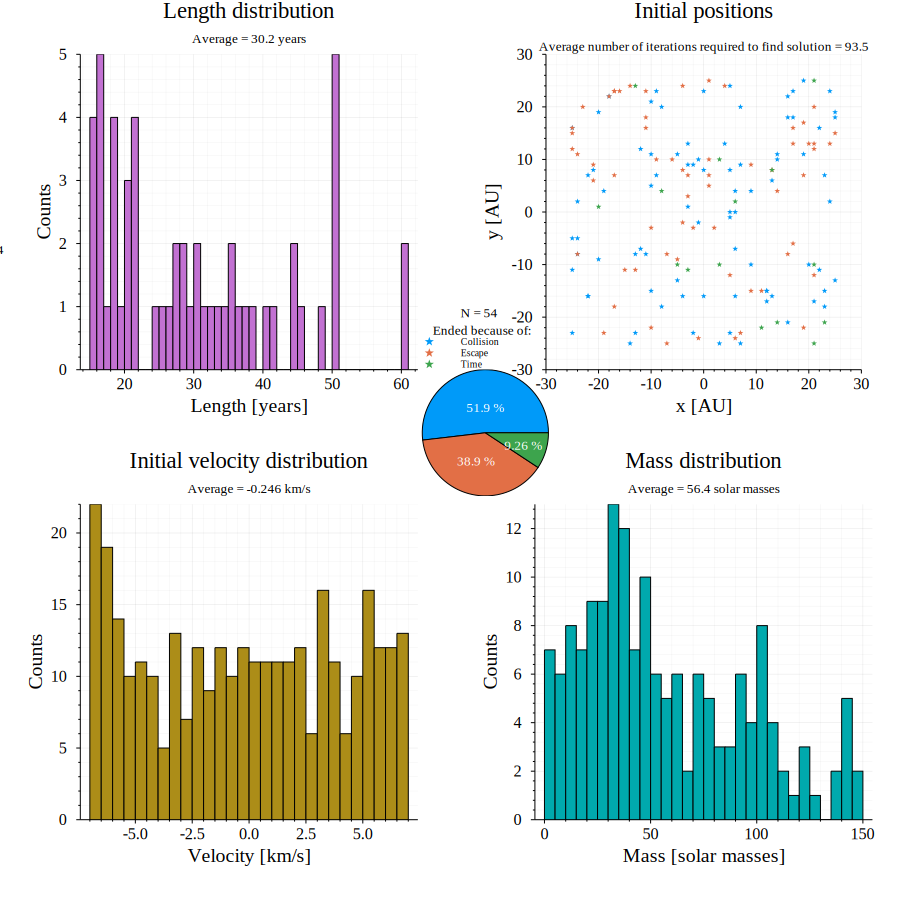

In [7]:
N=size(df)[1]; cFrac=size(df[df.collisionBool .== true,:])[1]/N; tFrac = size(df[(df.collisionBool .== false) .& (df.Length .== 50.0),:])[1]/N; eFrac = 1.0 - tFrac - cFrac 
collidedX=vcat(df[df.collisionBool .== true, :].x1, df[df.collisionBool .== true, :].x2, df[df.collisionBool .== true, :].x3)
collidedY=vcat(df[df.collisionBool .== true, :].y1, df[df.collisionBool .== true, :].y2, df[df.collisionBool .== true, :].y3)
timedOutX=vcat(df[(df.collisionBool .== false) .& (df.Length .== 50.0),:].x1,df[(df.collisionBool .== false) .& (df.Length .== 50.0),:].x2,df[(df.collisionBool .== false) .& (df.Length .== 50.0),:].x3)
timedOutY=vcat(df[(df.collisionBool .== false) .& (df.Length .== 50.0),:].y1,df[(df.collisionBool .== false) .& (df.Length .== 50.0),:].y2,df[(df.collisionBool .== false) .& (df.Length .== 50.0),:].y3)
escapedX=vcat(df[(df.collisionBool .== false) .& (df.Length .!= 50.0),:].x1,df[(df.collisionBool .== false) .& (df.Length .!= 50.0),:].x2,df[(df.collisionBool .== false) .& (df.Length .!= 50.0),:].x3)
escapedY=vcat(df[(df.collisionBool .== false) .& (df.Length .!= 50.0),:].y1,df[(df.collisionBool .== false) .& (df.Length .!= 50.0),:].y2,df[(df.collisionBool .== false) .& (df.Length .!= 50.0),:].y3)


default(fontfamily="times",minorgrid=true,widen=false,tickdirection=:out)
default(size=(1200,1000), xtickfontsize=10, ytickfontsize=10, xguidefontsize=12, yguidefontsize=12, legendfontsize=6, dpi=100)
p1=histogram(df.Length,label="",xlabel="Length [years]",ylabel="Counts",title="Length distribution",color=:4,bins=50)
p1=annotate!(((xlims(p1)[1]+xlims(p1)[2])/2,ylims(p1)[2]+0.05*ylims(p1)[2],Plots.text("Average = $(round(sum(df.Length)/N,sigdigits=3)) years","times",8)))
p1=pie!(["Collision","Escape","Time"],[cFrac,eFrac,tFrac],inset=(1,bbox(16/16,16/16,0.4,0.4)),title="",subplot=2,titlefontsize=8,legendfontsize=6,legend=false,
    foreground_color_legend=:transparent,background_color_legend=:transparent,background_color=:transparent,background_color_outside=:transparent,legendfontcolor=:white)
p1=annotate!((0,0.4,Plots.text("$(round(cFrac*100,sigdigits=3)) %","times","white",8)))
p1=annotate!((-0.15,-0.45,Plots.text("$(round(eFrac*100,sigdigits=3)) %","times","white",8)))
p1=annotate!((0.6,-0.2,Plots.text("$(round(tFrac*100,sigdigits=3)) %","times","white",8)))
p1=annotate!((-0.1,1.9,Plots.text("N = $N","times",8)))
p2=scatter(collidedX,collidedY,label="Collision",title="Initial positions",legendtitle="Ended because of:",legendtitlefontsize=8,
    foreground_color_legend=:transparent,background_color_legend=:transparent,xlabel="x [AU]",ylabel="y [AU]",legend=(-0.27,0.125),
    aspect_ratio=:equal,xlims=(-30,30),ylims=(-30,30),markersize=3,markershape=:star,markerstrokewidth=0)
p2=scatter!(escapedX,escapedY,label="Escape",markersize=3,markershape=:star,markerstrokewidth=0)
p2=scatter!(timedOutX,timedOutY,label="Time",markersize=3,markershape=:star,markerstrokewidth=0)
p2=annotate!((0.0,ylims(p2)[2]+0.05*ylims(p2)[2],Plots.text("Average number of iterations required to find solution = $(round(sum(df.iter)/N,sigdigits=3))","times",8)))
p3=histogram(vcat(df.vx1,df.vy1,df.vx2,df.vy2,df.vx3,df.vy3),label="",title="Initial velocity distribution",xlabel="Velocity [km/s]",ylabel="Counts",color=5,bins=50)
p3=annotate!((0.0,ylims(p3)[2]+0.05*ylims(p3)[2],Plots.text("Average = $(round(sum(vcat(df.vx1,df.vy1,df.vx2,df.vy2,df.vx3,df.vy3))/(6*N),sigdigits=3)) km/s","times",8)))
p4=histogram(vcat(df.m1,df.m2,df.m3),label="",title="Mass distribution",xlabel="Mass [solar masses]",ylabel="Counts",color=:6,bins=50)
p4=annotate!(((xlims(p4)[1]+xlims(p4)[2])/2,ylims(p4)[2]+0.05*ylims(p4)[2],Plots.text("Average = $(round(sum(vcat(df.m1,df.m2,df.m3))/(3*N),sigdigits=3)) solar masses","times",8)))
plot(p1,p2,p3,p4,layout=@layout[A B ; C D],size=(900,900),left_margin=5mm,right_margin=5mm,top_margin=5mm,bottom_margin=5mm)